In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

import numpy as np
import pandas as pd

from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

In [2]:
def load_clean(input_dir):
    data = pd.read_csv(input_dir)
    data = data.set_index("PassengerId")
    data["Embarked"] = data["Embarked"].replace({
        "C": "Cherbourg", 
        "Q": "Queenstown", 
        "S": "Southampton"
    })
    try:
        data["target"] = data["Survived"].replace({0:-1})
        data["Survived"] = data["Survived"].replace({0:"No", 1:"Yes"})
    except:
        # test data
        pass
    data["Pclass"] = data["Pclass"].replace({
        1: "1st_Class", 2: "2nd_Class", 3: "3rd_Class"
    })
    data["Alone"] = data[["SibSp", "Parch"]].sum(axis=1) == 0
    data["LastName"] = data["Name"].str.split(",", 1).str[0]
    last_names = data["LastName"].sort_values().value_counts()
    last_names.name = "LastNameCount"
    last_names = pd.DataFrame([last_names]).T
    last_names["FamilyGroup"] = np.arange(1, len(last_names)+1)
    last_names.loc[last_names["LastNameCount"] == 1, "FamilyGroup"] = 0
    data = data.merge(last_names, left_on="LastName", right_index=True).sort_index()
    cabins = data["Cabin"].str.split("\d").str[0]
    data["Deck"] = cabins[cabins.notna()]
    return data

input_dir = "data/titanic/train.csv"
data = load_clean(input_dir)
N = data.shape[0]
print("Number of observations:", N)
survived = (data["target"] == 1).sum()
survive_pct = survived / N
print(f"Survival percentage {survived/N:.1%} = ({survived} / {N}).\nDead {1-survived/N:.1%} = ({N - survived} / {N})")

Number of observations: 891
Survival percentage 38.4% = (342 / 891).
Dead 61.6% = (549 / 891)


In [3]:
test_dir = "data/titanic/test.csv"
test_data = load_clean(test_dir)

In [4]:
data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,target,Alone,LastName,LastNameCount,FamilyGroup,Deck
PassengerId,,,,,,,,,,,,,,,,,
1,No,3rd_Class,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,Southampton,-1,False,Braund,2,107,NaN
2,Yes,1st_Class,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,Cherbourg,1,False,Cumings,1,0,C
3,Yes,3rd_Class,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,Southampton,1,True,Heikkinen,1,0,NaN
4,Yes,1st_Class,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,Southampton,1,False,Futrelle,2,74,C
5,No,3rd_Class,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,Southampton,-1,True,Allen,2,98,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,No,2nd_Class,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,Southampton,-1,True,Montvila,1,0,NaN
888,Yes,1st_Class,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,Southampton,1,True,Graham,3,38,B
889,No,3rd_Class,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,Southampton,-1,False,Johnston,2,71,NaN


<AxesSubplot:xlabel='Age', ylabel='Count'>

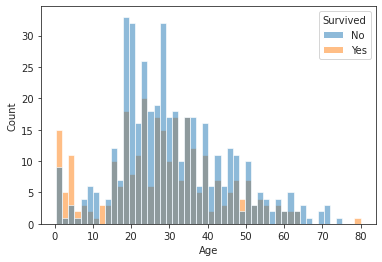

In [5]:
sns.histplot(data, x="Age", hue="Survived", bins=50)

<AxesSubplot:xlabel='Deck', ylabel='count'>

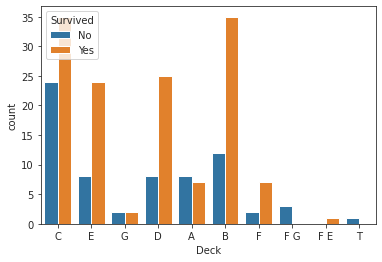

In [6]:
sns.countplot(data=data, x="Deck", hue="Survived")

In [7]:
data.isna().sum()

Survived           0
Pclass             0
Name               0
Sex                0
Age              177
SibSp              0
Parch              0
Ticket             0
Fare               0
Cabin            687
Embarked           2
target             0
Alone              0
LastName           0
LastNameCount      0
FamilyGroup        0
Deck             687
dtype: int64

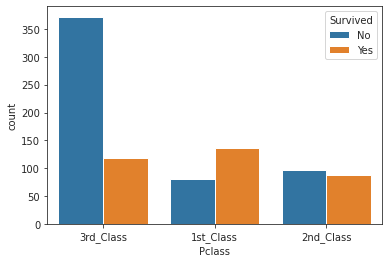

In [8]:
sns.countplot(data=data, x="Pclass", hue="Survived");

# Modeling

Trying out a least-squares classifier. Predict survived $\tilde y > 0$ where $\tilde y = X \beta + v$. The prediction takes the sign $\hat y = \textbf{sign}(\tilde y) \in \{ -1, 1\}$ for `No` or `Yes` Survived.

In [9]:
def roc(ytilde, y):
    alphas = np.linspace(-1, 1)
    cnf_list = []
    for alpha in alphas:
        yhat = np.sign(ytilde - alpha)
        cnf = confusion_matrix(y, yhat, labels=[1, -1]).ravel()
        cnf_list.append(cnf)
    # (tp, fn, fp, tn)
    cnf = np.append(alphas[:, np.newaxis], np.array(cnf_list), axis=1)

    fprate = cnf[:,3] / cnf[:, [3,4]].sum(axis=1)
    tprate = cnf[:,1] / cnf[:, [1,2]].sum(axis=1)
    error = 1 - cnf[:, [1,4]].sum(axis=1) / cnf[:,1:].sum(axis=1)
    a_opt = alphas[error.argmin()]
    print(f"Accuracy: {1 - error.min():.1%}")
    print(f"Alpha: {a_opt: .3f}")

    fig, axs = plt.subplots(1, 3, tight_layout=True, figsize=(12, 4))
    sns.histplot(x=ytilde, hue=data["Survived"], ax=axs[0], bins=30)
    axs[0].set_xlabel(r"$\tilde f(x^{(i)})$")
    axs[0].axvline(a_opt, ls="--", color="k")

    axs[1].plot(cnf[:,0], tprate,   label="True Positive Rate")
    axs[1].plot(cnf[:,0], fprate,   label="False Positive Rate")
    axs[1].plot(cnf[:,0], error,    label="Error Rate")
    axs[1].axvline(a_opt, ls="--", color="k")
    axs[1].legend(loc="upper right")
    axs[1].set_xlabel(r"$\alpha$")
    axs[1].set_ylabel("Rate")
   
    axs[2].plot(fprate, tprate)
    axs[2].set_xlabel("False Positive Rate")
    axs[2].set_ylabel("True Positive Rate")

    return cnf

In [10]:
X = pd.get_dummies(data["Pclass"], drop_first=True)
# X["Fare"] = preprocessing.scale(data["Fare"])
y = data["target"]

Accuracy: 67.9%
Alpha: -0.020


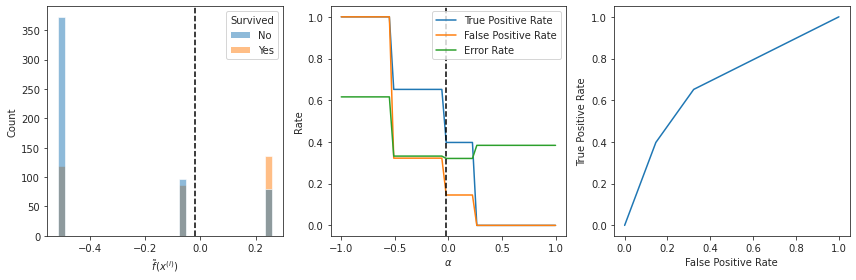

In [11]:
lm = linear_model.LinearRegression(fit_intercept=True)
lm.fit(X, y)
ytilde = lm.predict(X)
cnf = roc(ytilde, y)

A model just including the `Pclass` just uses the proportion of each class as a predictor. On the histogram, the 3 bars represent each class. The far-right is 1st class, which has the highest proportion of survival. The middle class is just below 0, meaning 2nd class is more likely to die. Far-left near -0.5 is 3rd class, which has a large proportion of dead people. Adjusting the classification decision $\alpha$ changes the true and false positive rate, and traces out the ROC curve.

,2nd_Class,3rd_Class,Fare,Alone,Teen,Child,Sex,A,B,C,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,1,-0.502445,0,0,0,1,0,0,0,...,-3.502445,-1.502445,1.502445,-1.502445,2.497555,0.497555,-0.497555,-2.497555,1.502445,-1.502445
2,0,0,0.786845,0,0,0,0,0,0,1,...,-1.213155,-1.213155,-2.786845,-1.213155,0.786845,0.786845,-0.786845,-0.786845,-0.786845,0.786845
3,0,1,-0.488854,1,0,0,0,0,0,0,...,-2.488854,-2.488854,2.488854,1.511146,1.511146,1.511146,-1.511146,0.488854,0.488854,-0.488854
4,0,0,0.420730,0,0,0,0,0,0,1,...,-1.579270,-1.579270,-2.420730,-1.579270,0.420730,0.420730,-0.420730,-0.420730,-0.420730,0.420730
5,0,1,-0.486337,1,0,0,1,0,0,0,...,-3.486337,-1.486337,3.486337,0.513663,2.513663,2.513663,-2.513663,-0.513663,-0.513663,0.513663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,1,0,-0.386671,1,0,0,1,0,0,0,...,-1.386671,-1.386671,3.386671,0.613329,0.613329,0.613329,-0.613329,1.386671,-2.613329,2.613329
888,0,0,-0.044381,1,0,0,0,0,1,0,...,-2.044381,-2.044381,2.044381,-0.044381,-0.044381,-0.044381,-1.955619,2.044381,-1.955619,1.955619
889,0,1,-0.176263,0,0,0,0,0,0,0,...,-0.176263,-4.176263,-1.823737,-2.176263,3.823737,1.823737,2.176263,0.176263,0.176263,-0.176263


Accuracy: 82.2%
Alpha: -0.020


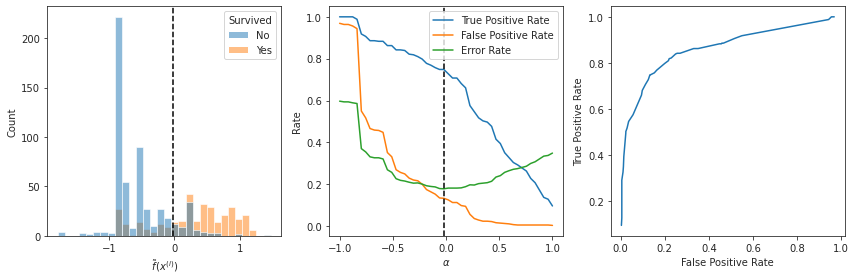

In [43]:
rng = np.random.default_rng(0)

X1 = X.copy()
X1["Fare"] = preprocessing.scale(data["Fare"])
X1["Alone"] = data["Alone"].astype(int)
X1["Teen"] = (data["Age"].between(6, 18)).astype(int)
X1["Child"] = (data["Age"] < 6).astype(int)             # look at histogram
X1["Sex"] = data["Sex"].replace({"female":0, "male":1}) # improves accuracy by 9%
X1 = X1.merge(pd.get_dummies(data["Deck"])[["A", "B", "C", "D", "E", "F"]], left_index=True, right_index=True)
X1["SibSp"] = data["SibSp"]
X1["Parch"] = data["Parch"]


lm.fit(X1, y)
ytilde = lm.predict(X1)
cnf = roc(ytilde, y)

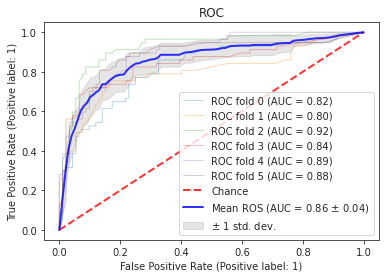

In [44]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
# classifier = svm.SVC(kernel="linear", probability=True, random_state=np.random.RandomState(0))
classifier = RandomForestClassifier()
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X1, y)):
    classifier.fit(X1.iloc[train], y.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X1.iloc[test], y.iloc[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0,1], [0,1], ls="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color="b",
        label=r"Mean ROS (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2, alpha=0.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper,
        color="grey", alpha=0.2, label=r"$\pm$ 1 std. dev.")

ax.set(
    xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
    title="ROC"
)
ax.legend(loc="lower right")

# Test

In [45]:
classifier.fit(X1, y)

Xt = pd.get_dummies(test_data["Pclass"], drop_first=True)
Xt["Fare"] = preprocessing.scale(test_data["Fare"])
Xt["Fare"] = Xt["Fare"].fillna(0)
Xt["Alone"] = test_data["Alone"].astype(int)
Xt["Teen"] = (test_data["Age"].between(6, 18)).astype(int)
Xt["Child"] = (test_data["Age"] < 6).astype(int)             # look at histogram
Xt["Sex"] = test_data["Sex"].replace({"female":0, "male":1}) # improves accuracy by 9%
Xt = Xt.merge(pd.get_dummies(test_data["Deck"])[["A", "B", "C", "D", "E", "F"]], left_index=True, right_index=True)
Xt["SibSp"] = test_data["SibSp"]
Xt["Parch"] = test_data["Parch"]

y_pred = classifier.predict(Xt).clip(0)
test_pred = pd.Series(y_pred, index=test_data.index)
test_pred.name="Survived"
test_pred.to_csv("data/titanic/submission.csv")